Download the dataset using cURL directly from kaggle.

In [8]:
%%bash
curl -L -o ~/Documents/GitHub/SQLcovid/corona-virus-report.zip \
  "https://www.kaggle.com/api/v1/datasets/download/imdevskp/corona-virus-report"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18.9M  100 18.9M    0     0  7056k      0  0:00:02  0:00:02 --:--:-- 10.1M


Unzip file into current folder.

In [9]:
%%bash
unzip -o ~/Documents/GitHub/SQLcovid/corona-virus-report.zip -d ~/Documents/GitHub/SQLcovid/

Archive:  /Users/joshuawb/Documents/GitHub/SQLcovid/corona-virus-report.zip
  inflating: /Users/joshuawb/Documents/GitHub/SQLcovid//country_wise_latest.csv  
  inflating: /Users/joshuawb/Documents/GitHub/SQLcovid//covid_19_clean_complete.csv  
  inflating: /Users/joshuawb/Documents/GitHub/SQLcovid//day_wise.csv  
  inflating: /Users/joshuawb/Documents/GitHub/SQLcovid//full_grouped.csv  
  inflating: /Users/joshuawb/Documents/GitHub/SQLcovid//usa_county_wise.csv  
  inflating: /Users/joshuawb/Documents/GitHub/SQLcovid//worldometer_data.csv  


We must pip install duckdb and pandas

In [13]:
import sys
!{sys.executable} -m pip install duckdb pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 51.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


Using DuckDB, we are able to directly create a SQL table from our csv in one line.

In [41]:
import pandas as pd
import duckdb as ddb

con = ddb.connect() 
con.execute("CREATE TABLE COVID AS SELECT * FROM 'worldometer_data.csv'")

df = con.execute("SELECT * FROM COVID").df()

df.head()

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,USA,North America,331198130,5032179,<NA>,162804,<NA>,2576668,<NA>,2292707,18296,15194,492.0,63139605,190640,Americas
1,Brazil,South America,212710692,2917562,<NA>,98644,<NA>,2047660,<NA>,771258,8318,13716,464.0,13206188,62085,Americas
2,India,Asia,1381344997,2025409,<NA>,41638,<NA>,1377384,<NA>,606387,8944,1466,30.0,22149351,16035,South-EastAsia
3,Russia,Europe,145940924,871894,<NA>,14606,<NA>,676357,<NA>,180931,2300,5974,100.0,29716907,203623,Europe
4,South Africa,Africa,59381566,538184,<NA>,9604,<NA>,387316,<NA>,141264,539,9063,162.0,3149807,53044,Africa


In [42]:
df.describe()

,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop
count,208.0,2.090000e+02,4.0,188.0,3.0,205.0,3.0,205.0,122.0,208.0,187.000000,191.0,191.0
mean,30415486.971154,9.171850e+04,1980.5,3792.590426,300.0,58878.980488,1706.0,27664.326829,534.393443,3196.024038,98.681176,1402404.701571,83959.366492
std,104766099.481173,4.325867e+05,3129.611424,15487.184877,451.199512,256698.406898,2154.779803,174632.736928,2047.518613,5191.986457,174.956862,5553366.670432,152730.59124
min,801.0,1.000000e+01,20.0,1.0,1.0,7.0,42.0,0.0,1.0,3.0,0.080000,61.0,4.0
25%,966314.0,7.120000e+02,27.5,22.0,40.5,334.0,489.0,86.0,3.25,282.0,6.000000,25752.0,8956.5
50%,7041972.5,4.491000e+03,656.0,113.0,80.0,2178.0,936.0,899.0,27.5,1015.0,29.000000,135702.0,32585.0
75%,25756135.5,3.689600e+04,2609.0,786.0,449.5,20553.0,2538.0,7124.0,160.25,3841.75,98.000000,757696.0,92154.5
max,1381344997.0,5.032179e+06,6590.0,162804.0,819.0,2576668.0,4140.0,2292707.0,18296.0,39922.0,1238.000000,63139605.0,995282.0


First 10 distinct countries in the dataset in alphabetical order.

In [49]:
con.execute("""
            SELECT C."Country/Region",  FROM COVID C
            ORDER BY 1
            LIMIT 10
            """).df()

,Country/Region
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola
5,Antigua and Barbuda
6,Argentina
7,Armenia
8,Aruba
9,Australia


Below we calculate the death rate across all countries and output the death rate for New Zealand. We can do this using a combination of pandas and SQL or do it full in SQL as shown in the next code block.

In [55]:
deathrates = con.execute("""
                            SELECT DISTINCT C."Country/Region", C.TotalCases, C.TotalDeaths, (TotalDeaths/TotalCases)*100 AS DeathRatePercentage
                            FROM COVID C
                        """).df()

deathrates.loc[lambda df: df["Country/Region"] == "New Zealand"]

,Country/Region,TotalCases,TotalDeaths,DeathRatePercentage
160,New Zealand,1569,22,1.402167


In [ ]:
con.execute("""
                SELECT DISTINCT C."Country/Region", C.TotalCases, C.TotalDeaths, (TotalDeaths/TotalCases)*100 AS DeathRatePercentage
                FROM COVID C
                WHERE C."Country/Region" = 'New Zealand'
            """).df()

,Country/Region,TotalCases,TotalDeaths,DeathRatePercentage
0,New Zealand,1569,22,1.402167


We also might like to see which countries had the highest death rate.

In [57]:
con.execute("""
                SELECT DISTINCT C."Country/Region", C.TotalCases, C.TotalDeaths, ROUND((TotalDeaths/TotalCases)*100,2) AS DeathRatePercentage
                FROM COVID C
                ORDER BY DeathRatePercentage DESC
                LIMIT 10
            """).df()

,Country/Region,TotalCases,TotalDeaths,DeathRatePercentage
0,Yemen,1768,508,28.73
1,France,195633,30312,15.49
2,UK,308134,46413,15.06
3,Italy,249204,35187,14.12
4,Belgium,71158,9859,13.86
5,Hungary,4597,600,13.05
6,Mexico,462690,50517,10.92
7,Netherlands,56982,6153,10.80
8,Sint Maarten,160,16,10.00
9,Western Sahara,10,1,10.00


We will now use the full grouped dataset to get the daily numbers to look at changes over time.

In [ ]:
con.execute("CREATE TABLE FULL_GROUPED AS SELECT * FROM 'full_grouped.csv'")

CatalogException: Catalog Error: Table with name "FULL_GROUPED" already exists!

This query calculates daily growth trends for each country by combining cumulative COVID-19 totals with SQL window functions.

The LAG() window function is used to look at the previous day’s values for each country (partitioned by country, ordered by date).
By subtracting the previous day’s cumulative totals from the current day’s totals, we derive:

 - new daily confirmed cases

 - new daily deaths

 - new daily recoveries

We also compute percentage growth, which helps compare countries of very different scales.

This shows that you can use SQL for time-series feature engineering without needing loops or procedural code

In [ ]:
daily_country_growth = con.execute("""
    WITH base AS (
        SELECT
            "Date"::DATE                     AS date,
            "Country/Region"                 AS country,
            Confirmed,
            Deaths,
            Recovered
        FROM FULL_GROUPED
    )
    SELECT
        country,
        date,
        Confirmed,
        Deaths,
        Recovered,
        -- daily deltas
        Confirmed - LAG(Confirmed) OVER (
            PARTITION BY country
            ORDER BY date
        ) AS new_confirmed,
        Deaths - LAG(Deaths) OVER (
            PARTITION BY country
            ORDER BY date
        ) AS new_deaths,
        Recovered - LAG(Recovered) OVER (
            PARTITION BY country
            ORDER BY date
        ) AS new_recovered,
        CASE
            WHEN LAG(Confirmed) OVER (PARTITION BY country ORDER BY date) > 0
            THEN (Confirmed - LAG(Confirmed) OVER (PARTITION BY country ORDER BY date))
                 * 100.0
                 / LAG(Confirmed) OVER (PARTITION BY country ORDER BY date)
        END AS pct_growth_confirmed
    FROM base
    ORDER BY country, date
""").df()

We can produce a plot very easily from this for any country or metric we want over time without much python code. The example below shows confirmed cases over time for New Zealand.

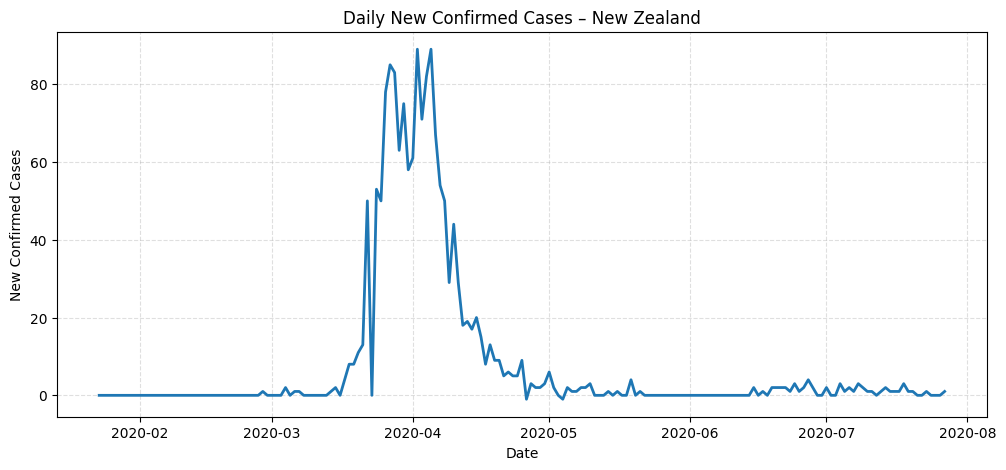

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# We can choose whichever country we would like to plot here
country_name = "New Zealand"

df_plot = (
    daily_country_growth
    .query("country == @country_name")
    .sort_values("date")
)

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["new_confirmed"], linewidth=2)

plt.title(f"Daily New Confirmed Cases – {country_name}")
plt.xlabel("Date")
plt.ylabel("New Confirmed Cases")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

This query answers the same question at the global level, but with an extra step.

First, all country data is aggregated by date to produce a global time series of cumulative confirmed cases, deaths, and recoveries.
Then, LAG() is applied to these global totals to calculate:

 - global new cases per day

 - global daily deaths

 - global recoveries

 - global percentage growth

This demonstrates your ability to:

Aggregate multi-country data into global summaries

Apply analytic window functions to an aggregated series

Produce interpretable metrics used widely in epidemiology and dashboard reporting

In [68]:
daily_global_growth = con.execute("""
    WITH daily_global AS (
        SELECT
            "Date"::DATE AS date,
            SUM(Confirmed) AS confirmed,
            SUM(Deaths)    AS deaths,
            SUM(Recovered) AS recovered
        FROM FULL_GROUPED
        GROUP BY date
    )
    SELECT
        date,
        confirmed,
        deaths,
        recovered,
        confirmed - LAG(confirmed) OVER (ORDER BY date) AS new_confirmed,
        deaths    - LAG(deaths)    OVER (ORDER BY date) AS new_deaths,
        recovered - LAG(recovered) OVER (ORDER BY date) AS new_recovered,
        CASE
            WHEN LAG(confirmed) OVER (ORDER BY date) > 0
            THEN (confirmed - LAG(confirmed) OVER (ORDER BY date))
                 * 100.0
                 / LAG(confirmed) OVER (ORDER BY date)
        END AS pct_growth_confirmed
    FROM daily_global
    ORDER BY date
""").df()

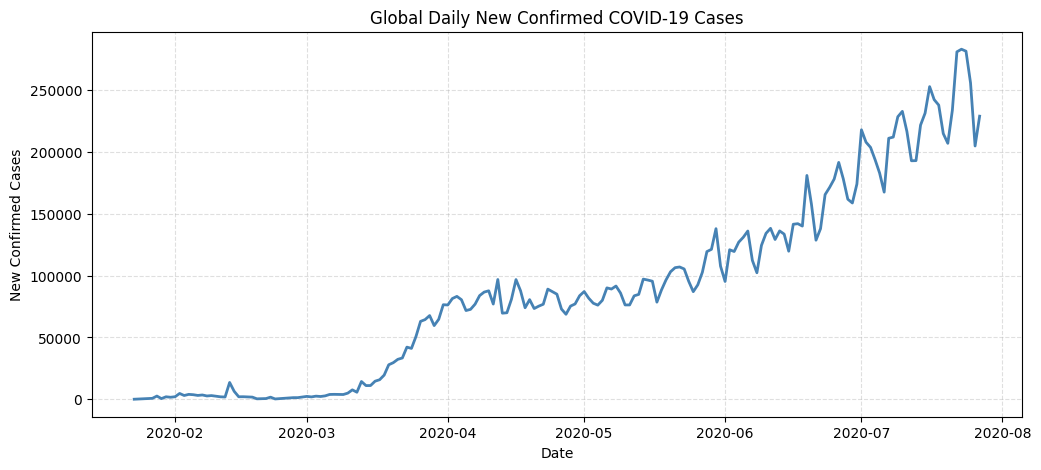

In [ ]:
# sort the data correctly just in case
dfg = daily_global_growth.sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(dfg["date"], dfg["new_confirmed"], linewidth=2, color="steelblue")

plt.title("Global Daily New Confirmed COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New Confirmed Cases")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

To find the countries with the fastest COVID-19 growth, I calculated each country’s daily percentage increase in confirmed cases. The data in the FULL_GROUPED table contains cumulative totals for each country, so the first step is to use a window function (LAG()) to look at the previous day’s confirmed cases. This allows us to measure how much cases increased from one day to the next.

Next, I computed a daily percentage growth rate, which shows how fast cases were rising relative to the previous total. Because daily numbers can be noisy, I also calculated a 7-day moving average using another window function. This smooths the trend and highlights real spikes instead of random fluctuations.

After computing these growth rates for every country and every date, I sorted the results by the highest 7-day average growth and selected the top 10 country–date combinations. These represent the periods where specific countries experienced the most rapid spread of COVID-19.

This analysis demonstrates several important SQL skills:

 - Using LAG() to calculate differences over time

 - Computing percentage growth from cumulative data

 - Applying window frames to create moving averages

 - Combining multiple steps using CTEs

 - Ranking results to identify the highest-growth events

In [72]:
top10_growth = con.execute("""
WITH base AS (
    SELECT
        "Date"::DATE AS date,
        "Country/Region" AS country,
        Confirmed,
        LAG(Confirmed) OVER (
            PARTITION BY "Country/Region"
            ORDER BY "Date"::DATE
        ) AS prev_confirmed
    FROM FULL_GROUPED
),

daily_growth AS (
    SELECT
        country,
        date,
        Confirmed,
        prev_confirmed,
        CASE
            WHEN prev_confirmed > 0 THEN 
                (Confirmed - prev_confirmed) * 100.0 / prev_confirmed
        END AS pct_growth
    FROM base
),

smoothed AS (
    SELECT
        country,
        date,
        pct_growth,
        AVG(pct_growth) OVER (
            PARTITION BY country
            ORDER BY date
            ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
        ) AS pct_growth_7d
    FROM daily_growth
    WHERE pct_growth IS NOT NULL
)

SELECT *
FROM smoothed
ORDER BY pct_growth_7d DESC
LIMIT 10;
""").df()

top10_growth

,country,date,pct_growth,pct_growth_7d
0,Bahrain,2020-02-25,2200.000000,2200.000000
1,Bahrain,2020-02-26,43.478261,1121.739130
2,Kuwait,2020-02-25,1000.000000,1000.000000
3,Bahrain,2020-02-27,0.000000,747.826087
4,Panama,2020-03-11,700.000000,700.000000
5,Kuwait,2020-02-26,136.363636,568.181818
6,Bahrain,2020-02-28,9.090909,563.142292
7,Brunei,2020-03-11,1000.000000,500.000000
8,Uzbekistan,2020-03-16,500.000000,500.000000
9,Bahrain,2020-02-29,13.888889,453.291612


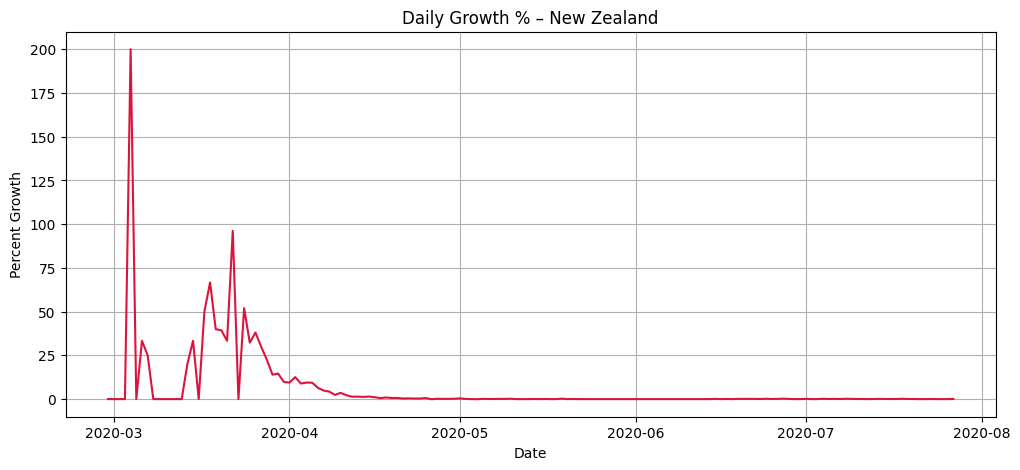

In [ ]:
# Plot percentage growth over time for specific country 
df_plot = con.execute(f"""
    WITH base AS (
        SELECT
            "Date"::DATE AS date,
            "Country/Region" AS country,
            Confirmed,
            LAG(Confirmed) OVER (
                PARTITION BY "Country/Region"
                ORDER BY "Date"::DATE
            ) AS prev_confirmed
        FROM FULL_GROUPED
    ),
    daily AS (
        SELECT *,
        CASE WHEN prev_confirmed > 0 THEN 
            (Confirmed - prev_confirmed) * 100.0 / prev_confirmed END AS pct_growth
        FROM base
    )
    SELECT date, pct_growth
    FROM daily
    WHERE country = '{country_name}'
    ORDER BY date
""").df()

plt.figure(figsize=(12,5))
plt.plot(df_plot["date"], df_plot["pct_growth"], color="crimson")
plt.title(f"Daily Growth % – {country_name}")
plt.xlabel("Date")
plt.ylabel("Percent Growth")
plt.grid(True)
plt.show()

This analysis focuses on understanding how severe COVID-19 was in each country by measuring the mortality rate, which is the percentage of confirmed cases that resulted in death.

To do this, I first grouped the data by country and month and calculated total confirmed cases and total deaths within each month. This gives a clean, time-based view that smooths out daily reporting noise.

Next, I computed the mortality rate for each country-month combination
	​
Countries are then sorted by highest mortality rate to highlight regions that were most severely impacted during any given month.

This query demonstrates several important SQL skills:

 - Date-based grouping using DATE_TRUNC('month', ...)

 - Aggregation of cumulative data into meaningful metrics

 - Conditional logic to safely handle zero or missing values

 - Chained CTEs for clear step-by-step analysis

 - Analytical ranking to identify the most affected countries

In [76]:
mortality_rate = con.execute("""
WITH monthly AS (
    SELECT
        "Country/Region"                         AS country,
        DATE_TRUNC('month', "Date"::DATE)        AS month,
        SUM(Confirmed)                           AS confirmed_total,
        SUM(Deaths)                              AS deaths_total
    FROM FULL_GROUPED
    GROUP BY country, month
),
mortality AS (
    SELECT
        country,
        month,
        confirmed_total,
        deaths_total,
        CASE 
            WHEN confirmed_total > 0 
            THEN deaths_total * 1.0 / confirmed_total
        END AS mortality_rate
    FROM monthly
)

SELECT *
FROM mortality
ORDER BY mortality_rate DESC NULLS LAST;
""").df()


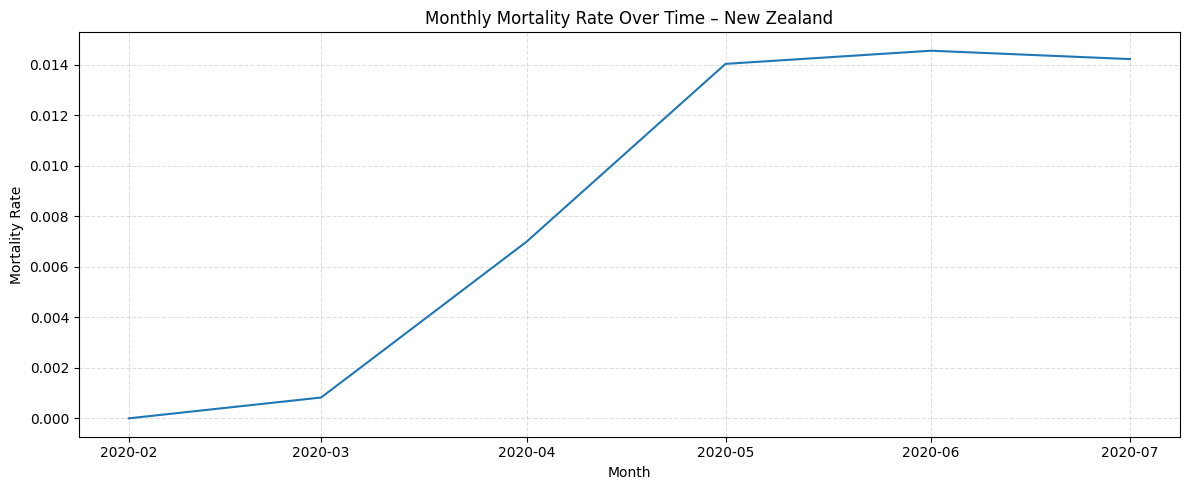

In [ ]:
# Plot for New Zealand - but could change to any. 
df_plot = (
    mortality_rate[mortality_rate['country'] == country_name]
    .sort_values('month')
)

plt.figure(figsize=(12, 5))
plt.plot(df_plot['month'], df_plot['mortality_rate'])

plt.title(f"Monthly Mortality Rate Over Time – {country_name}")
plt.xlabel("Month")
plt.ylabel("Mortality Rate")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

This analysis groups countries into similar COVID-19 outbreak patterns using SQL alone, without any machine learning. I engineered daily new-case and death metrics using window functions, then aggregated them into country-level features such as average cases, peak cases, and mortality rate. These metrics were normalised and bucketed into quartiles using NTILE() to create simple pattern profiles like C3_D2_M4. Countries with the same profile share similar outbreak dynamics, allowing SQL to act as a lightweight clustering tool.

In [ ]:
clustering = con.execute("""
WITH base AS (
    -- Daily new cases / deaths per country
    SELECT
        "Country/Region"                   AS country,
        "Date"::DATE                       AS date,
        Confirmed,
        Deaths,
        Confirmed - LAG(Confirmed) OVER (
            PARTITION BY "Country/Region"
            ORDER BY "Date"::DATE
        ) AS new_cases,
        Deaths - LAG(Deaths) OVER (
            PARTITION BY "Country/Region"
            ORDER BY "Date"::DATE
        ) AS new_deaths
    FROM FULL_GROUPED
),

country_stats AS (
    -- Aggregate to country-level outbreak metrics
    SELECT
        country,
        AVG(new_cases)                     AS avg_new_cases,
        MAX(new_cases)                     AS peak_new_cases,
        AVG(new_deaths)                    AS avg_new_deaths,
        MAX(new_deaths)                    AS peak_new_deaths,
        CASE 
            WHEN SUM(Confirmed) > 0 
            THEN SUM(Deaths) * 1.0 / SUM(Confirmed)
        END                                AS mortality_rate
    FROM base
    WHERE new_cases IS NOT NULL           -- drop first day per country
    GROUP BY country
),

normalized AS (
    -- Normalise metrics using global window averages
    SELECT
        country,
        avg_new_cases,
        peak_new_cases,
        avg_new_deaths,
        peak_new_deaths,
        mortality_rate,
        avg_new_cases   / NULLIF(AVG(avg_new_cases)   OVER (), 0) AS norm_avg_cases,
        avg_new_deaths  / NULLIF(AVG(avg_new_deaths)  OVER (), 0) AS norm_avg_deaths,
        mortality_rate  / NULLIF(AVG(mortality_rate)  OVER (), 0) AS norm_mortality
    FROM country_stats
),

ranked AS (
    -- Bucket countries into percentiles (quartiles here) per metric
    SELECT
        country,
        norm_avg_cases,
        norm_avg_deaths,
        norm_mortality,
        NTILE(4) OVER (ORDER BY norm_avg_cases)   AS cases_q,
        NTILE(4) OVER (ORDER BY norm_avg_deaths)  AS deaths_q,
        NTILE(4) OVER (ORDER BY norm_mortality)   AS mort_q
    FROM normalized
),

profiles AS (
    -- Build a simple "profile" label for cluster-like grouping
    SELECT
        country,
        cases_q,
        deaths_q,
        mort_q,
        'C' || cases_q || '_D' || deaths_q || '_M' || mort_q AS outbreak_profile
    FROM ranked
)

-- Final output: groups of countries with similar outbreak patterns
SELECT
    outbreak_profile,
    ARRAY_AGG(country ORDER BY country)   AS countries_in_group,
    COUNT(*)                              AS num_countries
FROM profiles
GROUP BY outbreak_profile
ORDER BY num_countries DESC, outbreak_profile;

""").df()


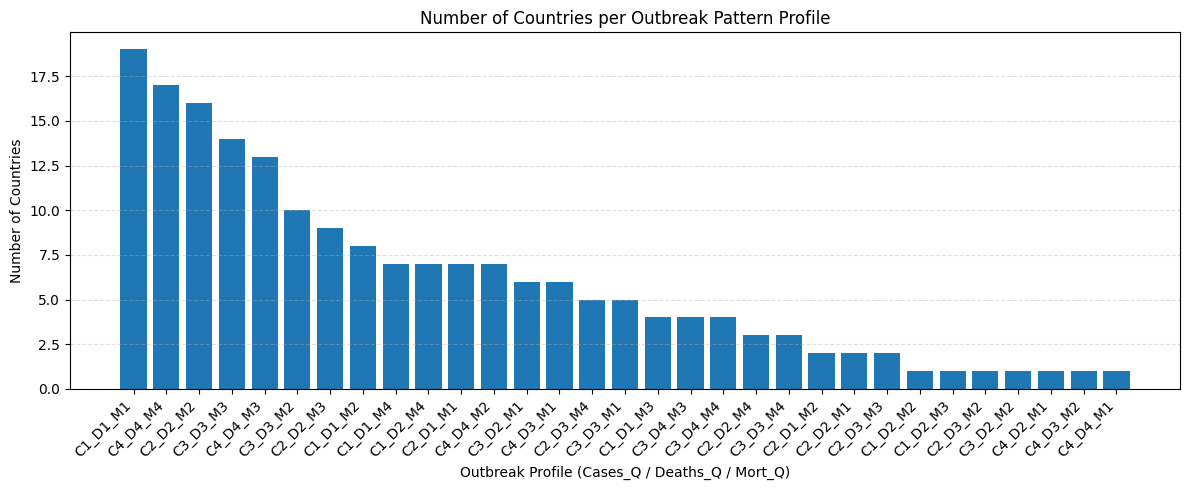

In [81]:
df = clustering.copy()  

plt.figure(figsize=(12, 5))
plt.bar(df["outbreak_profile"], df["num_countries"])

plt.title("Number of Countries per Outbreak Pattern Profile")
plt.xlabel("Outbreak Profile (Cases_Q / Deaths_Q / Mort_Q)")
plt.ylabel("Number of Countries")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [82]:
df = clustering.copy()

# Convert array/list into a comma-separated string
df_display = df.copy()
df_display["countries"] = df_display["countries_in_group"].apply(lambda x: ", ".join(x))

# Select clean columns
small_table = df_display[["outbreak_profile", "num_countries", "countries"]]

small_table

,outbreak_profile,num_countries,countries
0,C1_D1_M1,19,"Bhutan, Botswana, Burundi, Cambodia, Dominica,..."
1,C4_D4_M4,17,"Belgium, Brazil, Canada, China, Ecuador, Egypt..."
2,C2_D2_M2,16,"Benin, Cabo Verde, Equatorial Guinea, Eswatini..."
3,C3_D3_M3,14,"Austria, Bosnia and Herzegovina, Bulgaria, Cam..."
4,C4_D4_M3,13,"Bolivia, Colombia, Dominican Republic, Germany..."
5,C3_D3_M2,10,"Armenia, Australia, Azerbaijan, Ethiopia, Hait..."
6,C2_D2_M3,9,"Congo (Brazzaville), Cuba, Estonia, Libya, Lit..."
7,C1_D1_M2,8,"Brunei, Comoros, Jamaica, Lesotho, Liechtenste..."
8,C1_D1_M4,7,"Antigua and Barbuda, Bahamas, Barbados, Belize..."
9,C1_D2_M4,7,"Andorra, Angola, Burkina Faso, Chad, Guyana, S..."
